# Lab 8

In [1]:
from IPython.display import Audio
import matplotlib.pyplot as plt
import numpy as np
import scipy.constants as const
import scipy

## Intro

[Hydrogen](https://en.wikipedia.org/wiki/Hydrogen)

[minutephysics: The sound of hydrogen](https://www.youtube.com/watch?v=qyi5SvPlMXc)

[Tutorial: The sound of hydrogen](https://www.youtube.com/watch?v=IhvW8yZdE5A)

[jupyter notebook](https://nbviewer.jupyter.org/gist/Carreau/5507501/the%20sound%20of%20hydrogen.ipynb)

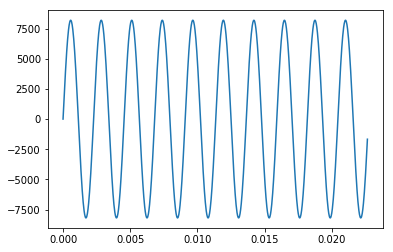

In [2]:
## some consstant for our audio file 

rate = 44100 #44.1 khz
duration =29 # in sec

# this will give us sin with the righ amplitude to use with wav files
normedsin = lambda f,t : 2**13*np.sin(2*np.pi*f*t)

time = np.linspace(0,duration, num=rate*duration)
# define A as a 440 Hz sin function 
la = lambda t : normedsin(440,t)

# look at it on the first 25 ms
plt.plot(time[0:1000], la(time)[0:1000])

In [3]:
from scipy.io import wavfile

In [4]:
wavfile.write('440.wav', rate, la(time).astype(np.int16))

In [5]:
Audio("440.wav")

In [6]:
# fondamental frequency of hydrogen
f0 = const.Rydberg*const.c
print("The highest frequency of hydrogen is ",f0,"Hz. and correspond to n = 1, m = ∞")
fshift = 440
print("we can shift the spectrum for it to be at 440 Hz (A)")

The highest frequency of hydrogen is  3289841960355208.5 Hz. and correspond to n = 1, m = ∞
we can shift the spectrum for it to be at 440 Hz (A)


In [7]:
ryd = lambda n,m : fshift*(1/(n**2) -1/(m**2))
flyman = lambda x : ryd(1,x)
fbalmer = lambda x : ryd(2,x)

In [8]:
## define the sum, 
ser = lambda t : sum( [normedsin(flyman(i),t)+normedsin(fbalmer(i+1),t) for i in range(2,8)])

# and a verorialized function to work on a by element basis with matlab
serv = scipy.vectorize(ser)

In [9]:
ss = serv(time)

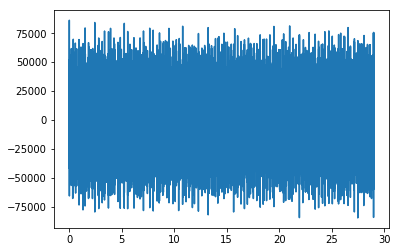

In [10]:
plt.plot(time,ss)
ss = 2**15*ss/ ss.max()

In [11]:
wavfile.write('hydrogen.wav', rate, ss.astype(np.int16))


In [12]:
Audio('hydrogen.wav')

# Gaussian Mixture Model HMM

In [13]:
import os

In [14]:
#Files are signed 16 bit raw, sample rate 8000
os.system("cat ./audio/banana/banana01.wav | aplay -f S16_LE -t wav -r 8000")

255

In [15]:
fpaths = []
labels = []
spoken = []
for f in os.listdir('audio'):
    for w in os.listdir('audio/' + f):
        fpaths.append('audio/' + f + '/' + w)
        labels.append(f)
        if f not in spoken:
            spoken.append(f)
print(spoken)

['apple', 'banana', 'kiwi', 'lime', 'orange', 'peach', 'pineapple']


In [16]:
data = np.zeros((len(fpaths), 32000))
maxsize = -1
for n,file in enumerate(fpaths):
    _, d = wavfile.read(file)
    data[n, :d.shape[0]] = d
    if d.shape[0] > maxsize:
        maxsize = d.shape[0]
data = data[:, :maxsize]

In [17]:
#Each sample file is one row in data, and has one entry in labels
print('Samples:', data.shape[0])
all_labels = np.zeros(data.shape[0])
for n, l in enumerate(set(labels)):
    all_labels[np.array([i for i, _ in enumerate(labels) if _ == l])] = n
    
print('Label indices:', all_labels)

Samples: 105
Label indices: [5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.
 4. 4. 4. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1.]


## GMM-HMM implementation

### Task 1: implement GMM-HMM by Baum-Welch expectation maximization algorithm

Use hint below for your implementation

[Hidden Markov Models
](http://cs.brown.edu/research/ai/dynamics/tutorial/Documents/HiddenMarkovModels.html)

[HMMs Baum-Welch](http://www.biostat.jhsph.edu/bstcourse/bio638/notes/HMMs_BaumWelch.pdf)

HMMs must do three primary tasks:

- State Estimation $P(S | O)$ - can be useful if you have prior info about what states mean and create the state probabilities yourself.
- Path Estimation - given observations, what is the most likely "state path"? Not useful in our case, and not even implemented here!
- Maximum Likelihood Estimation $P(O | \lambda)$ - learn the HMM parameters $\lambda$ which maximize the probability of observations. This is the primary method we will use.

To train the HMM, use the Baum-Welch algorithm.

In [18]:
import scipy.stats as st

class gmmhmm:
    
    def __init__(self, n_states):
        self.n_states = n_states
        self.random_state = np.random.RandomState(42)
        self.prior = self._normalize(self.random_state.rand(n_states, 1))
        self.A = self._stochasticize(self.random_state.rand(n_states, n_states))
        
        self.mu = None
        self.covs = None
        self.n_dims = None
           
            
    def _forward(self, B):
        log_likelihood = 0.0
        T = B.shape[1]
        alpha = np.zeros(B.shape)
        for ind in range(T):
            B_t = B[:, ind]

            alpha[:, ind] = B_t
            if ind == 0:
                alpha[:, ind] *= self.prior.ravel()
            else:
                alpha[:, ind] *= np.dot(self.A.T, alpha[:, ind - 1])
            # normalization:
            s_alphas = np.sum(alpha[:, ind])
            alpha[:, ind] /= s_alphas
            log_likelihood += np.log(s_alphas)
            
        return log_likelihood, alpha
    
    
    def _backward(self, B):
        T = B.shape[1]
        beta = np.zeros(B.shape);
           
        beta[:, -1] = np.ones(B.shape[0])
        
        for ind in range(T - 1)[::-1]:
            beta[:, ind] = np.dot(self.A, B[:, ind + 1] * beta[:, ind + 1])
            beta[:, ind] /= np.sum(beta[:, ind])
        
        return beta
    
    
    def _state_likelihood(self, obs):
        obs = np.atleast_2d(obs)
        B = np.zeros((self.n_states, obs.shape[1]))
        for state in range(self.n_states):
            B[state, :] = st.multivariate_normal.pdf(obs.T, mean=self.mu[:, state].T, cov=self.covs[:, :, state].T)
        return B
    
    
    def _normalize(self, x):
        res = x / (np.sum(x) + (np.sum(x) == 0))
        return res
    
    
    def _stochasticize(self, x):
        res = np.array([self._normalize(xi) for xi in x])
        return res
    
    
    def _em_step(self, obs): 
        
        if self.n_dims is None:
            self.n_dims = len(obs)
            
        if self.mu is None:
            selected_obs = self.random_state.choice(np.arange(self.n_dims), size=self.n_states, replace=False)
            self.mu = obs[:, selected_obs]
        
        if self.covs is None:
            dims = (self.n_dims, self.n_dims, self.n_states)
            self.covs = np.zeros(shape=dims) + np.diag(np.diag(np.cov(obs)))[:, :, None]
        
        
        obs = np.atleast_2d(obs)
        B = self._state_likelihood(obs)
        length = obs.shape[1]
        
        log_likelihood, alpha = self._forward(B)
        beta = self._backward(B)
        xi_sum = np.zeros((self.n_states, self.n_states))
        gamma = np.zeros((self.n_states, length))
        
        
        for index in range(length - 1):
            partial_sum = self.A * np.dot(alpha[:, index], (beta[:, index] * B[:, index + 1]).T)
            xi_sum += self._normalize(partial_sum)
            partial_g = alpha[:, index] * beta[:, index]
            gamma[:, index] = self._normalize(partial_g)
              
        partial_g = alpha[:, -1] * beta[:, -1]
        gamma[:, -1] = self._normalize(partial_g)
        expected_prior = gamma[:, 0]
        expected_A = self._stochasticize(xi_sum)
        expected_mu = np.zeros((self.n_dims, self.n_states))
        expected_covs = np.zeros((self.n_dims, self.n_dims, self.n_states))
        
        gamma_state_sum = np.sum(gamma, axis=1)
        gamma_state_sum = gamma_state_sum + (gamma_state_sum == 0)
        
        for s in range(self.n_states):
            gamma_obs = obs * gamma[s, :]
            expected_mu[:, s] = np.sum(gamma_obs, axis=1) / gamma_state_sum[s]
        
        expected_covs += .01 * np.eye(self.n_dims)[:, :, None]
        self.prior = expected_prior
        self.mu = expected_mu
        self.covs = expected_covs
        self.A = expected_A
        
        return log_likelihood
    
    def fit(self, obs, n_iter=15):
        #Support for 2D and 3D arrays
        #2D should be n_features, n_dims
        #3D should be n_examples, n_features, n_dims
        #For example, with 6 features per speech segment, 105 different words
        #this array should be size
        #(105, 6, X) where X is the number of frames with features extracted
        #For a single example file, the array should be size (6, X)

        # YOUR CODE HERE
        if len(obs.shape) == 2:
            for i in range(n_iter):
                log_likelihood = self._em_step(obs)
                
        if len(obs.shape) == 3:
            for o in range(len(obs)):
                for i in range(n_iter):
                    log_likelihood = self._em_step(obs[o, :, :])
        
        return self
    
    
    def transform(self, obs):
        #Support for 2D and 3D arrays
        #2D should be n_features, n_dims
        #3D should be n_examples, n_features, n_dims
        #For example, with 6 features per speech segment, 105 different words
        #this array should be size
        #(105, 6, X) where X is the number of frames with features extracted
        #For a single example file, the array should be size (6, X)
        res = None
        if len(obs.shape) == 2:
            B = self._state_likelihood(obs)
            log_likelihood, _ = self._forward(B)
            res = log_likelihood
        elif len(obs.shape) == 3:
            count = len(obs)
            res = np.zeros((count,))
            for n in range(count):
                B = self._state_likelihood(obs[n, :, :])
                log_likelihood, _ = self._forward(B)
                res[n] = log_likelihood
        
        return res

### Task 2: test your implementation

In [19]:
rstate = np.random.RandomState(0)
t1 = np.ones((4, 40)) + .001 * rstate.rand(4, 40)
t1 /= t1.sum(axis=0)
t2 = rstate.rand(*t1.shape)
t2 /= t2.sum(axis=0)

m1 = gmmhmm(2)
m1.fit(t1)
m2 = gmmhmm(2)
m2.fit(t2)

m1t1 = m1.transform(t1)
m2t1 = m2.transform(t1)
print("Likelihoods for test set 1")
print("M1:", m1t1)
print("M2:", m2t1)
print("Prediction for test set 1")
print("Model", np.argmax([m1t1, m2t1]) + 1)
print()

m1t2 = m1.transform(t2)
m2t2 = m2.transform(t2)
print("Likelihoods for test set 2")
print("M1:", m1t2)
print("M2:", m2t2)
print("Prediction for test set 2")
print("Model", np.argmax([m1t2, m2t2]) + 1)

Likelihoods for test set 1
M1: 221.38341872044367
M2: 171.67020415230365
Prediction for test set 1
Model 1

Likelihoods for test set 2
M1: 33.189742886242534
M2: 70.022391032926
Prediction for test set 2
Model 2


## Dataset Models

To predict words, we need to train 7 separate GMM-HMM models, one for each word. We will then feed the features for a test sample into each, choosing the word associated with the GMM-HMM having the highest output likelihood. This maximum likelihood estimate is our best guess for what word was spoken.

### Task 3: train 7 separate models

In [20]:
from python_speech_features import mfcc
from sklearn.model_selection import StratifiedShuffleSplit

preproc_data = []
for d in data:
    frames = np.abs(mfcc(d, samplerate=rate, winlen=0.01, nfft=2000)).T 
    frames /= np.sum(frames,axis=0)
    preproc_data.append(frames)

preproc_data = np.array(preproc_data)
print("Preprocessed data shape:", preproc_data.shape)
n_features = preproc_data.shape[1]

def get_samples(data, label, labels):
    return data[labels==label]

gmmhmms = []
model_cnt = 0
for label in set(labels):
    gmmhmms.append(gmmhmm(n_features))
    samples = get_samples(preproc_data, label, all_labels)
    gmmhmms[-1].fit(samples)
    model_cnt += 1
    print(f'GMM-HMM model {model_cnt} for {label} was fitted.')

Preprocessed data shape: (105, 13, 16)
GMM-HMM model 1 for peach was fitted.
GMM-HMM model 2 for pineapple was fitted.
GMM-HMM model 3 for lime was fitted.
GMM-HMM model 4 for banana was fitted.
GMM-HMM model 5 for orange was fitted.
GMM-HMM model 6 for apple was fitted.
GMM-HMM model 7 for kiwi was fitted.


C:\Users\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  from ipykernel import kernelapp as app


### Task 4: check accuracy on train/test split

In [21]:
sss = StratifiedShuffleSplit(n_splits=2, test_size=0.1, random_state=13)

for n,i in enumerate(preproc_data):
    preproc_data[n] /= preproc_data[n].sum(axis=0)

for train_index, test_index in sss.split(preproc_data, all_labels):
    X_train, X_test = preproc_data[train_index, ...], preproc_data[test_index, ...]
    y_train, y_test = all_labels[train_index], all_labels[test_index]
    
print('Size of training matrix ', X_train.shape)
print('Size of testing matrix ', X_test.shape)

ys = set(all_labels)
models = [gmmhmm(n_features) for y in ys]
_ = [model.fit(X_train[y_train == y, :]) for model, y in zip(models, ys)]

ps = [model.transform(X_test) for model in models]
res = np.vstack(ps)
y_pred = np.argmax(res, axis=0)
print('accuracy on test data:')
print((100 * (1 - np.mean(y_pred != y_test))))

Size of training matrix  (94, 13, 16)
Size of testing matrix  (11, 13, 16)
accuracy on test data:
90.9090909090909


### Task 5: provide confusion matrix for prediction

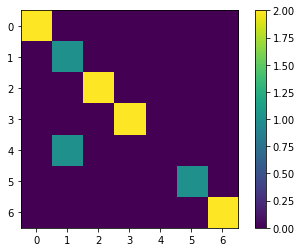

In [22]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)
plt.imshow(conf_mat)
plt.colorbar()
plt.show()